# Creating the time series

This notebook cleans a day-ahead electricity-price dataset with two recurring DST issues:

* Autumn “clock-back” – local time 02:00 appears twice (duplicate rows).
* Spring “clock-forward” – local time 02:00 never appears (missing row, 01:00 → 03:00).

The goal is to:

* Collapse the duplicate autumn hour into a single row whose numeric values are the mean of the two originals.
* Insert the missing spring hour and fill it with the mean of its neighbours (01:00 & 03:00).
* Verify that after these fixes every Area × Sequence series is strictly hourly.

In [12]:
# Load libraries

# File-system / environment handling
import os

# Data manipulation & analysis
import pandas as pd
import matplotlib.pyplot as plt

# Interactive widgets (Jupyter UI) and notebook display utilities
import ipywidgets as widgets
from IPython.display import display, clear_output

 ## Step 1: Load and Combine CSV Files

 **Goal:** Aggregate multiple CSV files of the electricity prices from various countries into a single DataFrame. Then, create a interactive selector to use Australia or Europe data.

In [2]:
# Combine the CSV files for europe
folder_path = 'data/spain_france_portugal' 
dfs = []  # List to store each individual DataFrame

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)


In [3]:
# Create dropdown for selecting 'europe' or 'australia'
option_selector = widgets.Dropdown(
    options=['europe', 'australia'],
    value='europe',  # initial default
    description='Dataset:',
    disabled=False,
)

# Create button
button = widgets.Button(
    description="Load Dataset",
    button_style='success',  
    tooltip='Click to load selected dataset',
    icon='check' 
)

# Define button click handler
def on_button_click(b):
    global combined_df
    clear_output(wait=True)  # Clears previous output to keep it clean
    display(option_selector, button)  # Re-display widgets after clear
    
    selected_option = option_selector.value
    
    if selected_option == 'europe':
        combined_df = combined_df.copy()
        print("Europe dataset selected (combined_df copied).")
        print(combined_df.head())
    
    elif selected_option == 'australia':
        file_path = 'parquet_files/australia_data.parquet'
        try:
            combined_df = pd.read_parquet(file_path)
            print(f"Australia dataset loaded from {file_path}.")
            print(combined_df.head())
        except Exception as e:
            print(f"Error loading Australia dataset: {e}")

# Attach button click handler
button.on_click(on_button_click)

# Display UI
display(option_selector, button)


Dropdown(description='Dataset:', options=('europe', 'australia'), value='europe')

Button(button_style='success', description='Load Dataset', icon='check', style=ButtonStyle(), tooltip='Click t…

In [4]:
# Inspect the data

combined_df.head()

,MTU (CET/CEST),Area,Sequence,Day-ahead Price (EUR/MWh),Intraday Period (CET/CEST),Intraday Price (EUR/MWh)
0,01/01/2021 00:00:00 - 01/01/2021 01:00:00,BZN|ES,Without sequence,50.87,NaN,NaN
1,01/01/2021 01:00:00 - 01/01/2021 02:00:00,BZN|ES,Without sequence,48.19,NaN,NaN
2,01/01/2021 02:00:00 - 01/01/2021 03:00:00,BZN|ES,Without sequence,44.68,NaN,NaN
3,01/01/2021 03:00:00 - 01/01/2021 04:00:00,BZN|ES,Without sequence,38.50,NaN,NaN
4,01/01/2021 04:00:00 - 01/01/2021 05:00:00,BZN|ES,Without sequence,36.80,NaN,NaN


 ## Step 2: Examine Columns and Rows in the data

 **Goal:** Understand the structure of the merged dataset.

In [5]:
print('The columns are: ', [col for col in combined_df.columns])
print('Number of rows: ', len(combined_df))


The columns are:  ['MTU (CET/CEST)', 'Area', 'Sequence', 'Day-ahead Price (EUR/MWh)', 'Intraday Period (CET/CEST)', 'Intraday Price (EUR/MWh)']
Number of rows:  115485


 ## Step 3: Extract and Clean Start Times

 **Goal:** Parse the 'MTU (CET/CEST)' column to derive clean start datetime values. 

In [6]:
start_times = combined_df['MTU (CET/CEST)'].str.split(' - ').str[0]
start_times_clean = start_times.str.replace(r' \(CET\)| \(CEST\)', '', regex=True)
combined_df['Start DateTime'] = pd.to_datetime(start_times_clean, dayfirst=True)
combined_df.head(10)


,MTU (CET/CEST),Area,Sequence,Day-ahead Price (EUR/MWh),Intraday Period (CET/CEST),Intraday Price (EUR/MWh),Start DateTime
0,01/01/2021 00:00:00 - 01/01/2021 01:00:00,BZN|ES,Without sequence,50.87,NaN,NaN,2021-01-01 00:00:00
1,01/01/2021 01:00:00 - 01/01/2021 02:00:00,BZN|ES,Without sequence,48.19,NaN,NaN,2021-01-01 01:00:00
2,01/01/2021 02:00:00 - 01/01/2021 03:00:00,BZN|ES,Without sequence,44.68,NaN,NaN,2021-01-01 02:00:00
3,01/01/2021 03:00:00 - 01/01/2021 04:00:00,BZN|ES,Without sequence,38.50,NaN,NaN,2021-01-01 03:00:00
4,01/01/2021 04:00:00 - 01/01/2021 05:00:00,BZN|ES,Without sequence,36.80,NaN,NaN,2021-01-01 04:00:00
5,01/01/2021 05:00:00 - 01/01/2021 06:00:00,BZN|ES,Without sequence,36.55,NaN,NaN,2021-01-01 05:00:00
6,01/01/2021 06:00:00 - 01/01/2021 07:00:00,BZN|ES,Without sequence,36.60,NaN,NaN,2021-01-01 06:00:00
7,01/01/2021 07:00:00 - 01/01/2021 08:00:00,BZN|ES,Without sequence,36.55,NaN,NaN,2021-01-01 07:00:00
8,01/01/2021 08:00:00 - 01/01/2021 09:00:00,BZN|ES,Without sequence,36.55,NaN,NaN,2021-01-01 08:00:00
9,01/01/2021 09:00:00 - 01/01/2021 10:00:00,BZN|ES,Without sequence,36.55,NaN,NaN,2021-01-01 09:00:00


 ## Step 4: Filter Data by Time Interval

 **Goal:** Keep only rows that fall within the desired datetime range.

In [15]:
if option_selector.value == 'australia':
    filtered_df = combined_df.copy()
    print(filtered_df['Start DateTime'].head(5))
    print(filtered_df['Start DateTime'].tail(5))
else:
    start_date = pd.to_datetime('2021-05-21')  # Lower bound for filtering
    end_date = pd.to_datetime('2025-05-01')    # Upper bound (exclusive)
    filtered_df = combined_df[(combined_df['Start DateTime'] >= start_date) & (combined_df['Start DateTime'] < end_date)]
    print(filtered_df['Start DateTime'].head(5))
    print(filtered_df['Start DateTime'].tail(5))


3359   2021-05-21 00:00:00
3360   2021-05-21 01:00:00
3361   2021-05-21 02:00:00
3362   2021-05-21 03:00:00
3363   2021-05-21 04:00:00
Name: Start DateTime, dtype: datetime64[ns]
114928   2025-04-30 19:00:00
114929   2025-04-30 20:00:00
114930   2025-04-30 21:00:00
114931   2025-04-30 22:00:00
114932   2025-04-30 23:00:00
Name: Start DateTime, dtype: datetime64[ns]


## Step 5: Detect Irregular Time Intervals

Identify gaps or anomalies in the hourly data sequence grouped by Area and Sequence.  These datetimes are like this because of the Daylight Saving Time (DST).

In [16]:
###############################################################################
# 1.  Collapse the duplicate hour (02:00 appears twice in the autumn) ---------
###############################################################################

# group by the full key INCLUDING the timestamp and just take the mean
# of every numeric column you care about (here I assume a 'Value' column)
if option_selector.value == 'europe':
  collapsed = (
      filtered_df
        .groupby(['Area', 'Sequence', 'Start DateTime'], as_index=False)
        .agg({'Day-ahead Price (EUR/MWh)': 'mean'})          
        .sort_values(['Area', 'Sequence', 'Start DateTime'])
  )

In [17]:
###############################################################################
# 2.  Create a complete hourly grid and fill the spring gap -------------------
###############################################################################
def fill_missing_hour(group: pd.DataFrame) -> pd.DataFrame:
    """
    Re-index each Area/Sequence sub-frame to an *hourly* grid and
    interpolate the missing spring-forward hour.  Static columns
    (Area, Sequence, etc.) are copied back onto the new rows so they
    remain in the same group later on.
    """
    # full hourly index, still in local (naïve) time
    idx = pd.date_range(
        start=group['Start DateTime'].iloc[0],
        end  =group['Start DateTime'].iloc[-1],
        freq='H'
    )

    out = (
        group
        .set_index('Start DateTime')        # put time in index
        .reindex(idx)                       # insert 02:00 row
        .interpolate(method='time')         # numeric columns
        .reset_index()
        .rename(columns={'index': 'Start DateTime'})
    )

    # copy constant columns onto the new row(s)
    const_cols = ['Area', 'Sequence']                  
    for c in const_cols:
        out[c] = group[c].iloc[0]

    return out



# normalise once and reuse
choice = option_selector.value.strip().lower()

if choice == 'europe':
    filtered_df = (
        collapsed
        .groupby(['Area', 'Sequence'], group_keys=False)
        .apply(fill_missing_hour)
        .sort_values(['Area', 'Sequence', 'Start DateTime'])
        .reset_index(drop=True)
    )
    display(filtered_df.head())          
else:
    print(f"Skipping DST fix because choice = {option_selector.value!r}")


C:\Users\frolo\AppData\Local\Temp\ipykernel_25940\110134008.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group
C:\Users\frolo\AppData\Local\Temp\ipykernel_25940\110134008.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group
C:\Users\frolo\AppData\Local\Temp\ipykernel_25940\110134008.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group


,Start DateTime,Area,Sequence,Day-ahead Price (EUR/MWh)
0,2021-05-21 00:00:00,BZN|ES,Without sequence,80.85
1,2021-05-21 01:00:00,BZN|ES,Without sequence,79.46
2,2021-05-21 02:00:00,BZN|ES,Without sequence,79.18
3,2021-05-21 03:00:00,BZN|ES,Without sequence,79.18
4,2021-05-21 04:00:00,BZN|ES,Without sequence,79.46


In [18]:
# Check that there are not irregular times anymore

if option_selector.value == 'australia':
    minutes = 5
else:
    minutes = 60

filtered_df = filtered_df.sort_values(['Area', 'Sequence', 'Start DateTime']).reset_index(drop=True)
filtered_df['TimeDiff'] = filtered_df.groupby(['Area', 'Sequence'])['Start DateTime'].diff()
filtered_df['NonHourly'] = (filtered_df['TimeDiff'] != pd.Timedelta(minutes=minutes)) & (~filtered_df['TimeDiff'].isna())

problem_indices = filtered_df.index[filtered_df['NonHourly']]
context_indices = problem_indices.union(problem_indices - 1)

irregular_context = filtered_df.loc[context_indices].sort_values(['Area', 'Sequence', 'Start DateTime'])
print(irregular_context[['Area', 'Sequence', 'Start DateTime', 'TimeDiff']].head(10))
print(irregular_context['TimeDiff'].unique())


Empty DataFrame
Columns: [Area, Sequence, Start DateTime, TimeDiff]
Index: []
<TimedeltaArray>
[]
Length: 0, dtype: timedelta64[ns]


## Step 6: Descriptive statistics

In [19]:
filtered_df.head()

,Start DateTime,Area,Sequence,Day-ahead Price (EUR/MWh),TimeDiff,NonHourly
0,2021-05-21 00:00:00,BZN|ES,Without sequence,80.85,NaT,False
1,2021-05-21 01:00:00,BZN|ES,Without sequence,79.46,0 days 01:00:00,False
2,2021-05-21 02:00:00,BZN|ES,Without sequence,79.18,0 days 01:00:00,False
3,2021-05-21 03:00:00,BZN|ES,Without sequence,79.18,0 days 01:00:00,False
4,2021-05-21 04:00:00,BZN|ES,Without sequence,79.46,0 days 01:00:00,False


LaTeX table saved to: latex_files\stats_europe.tex


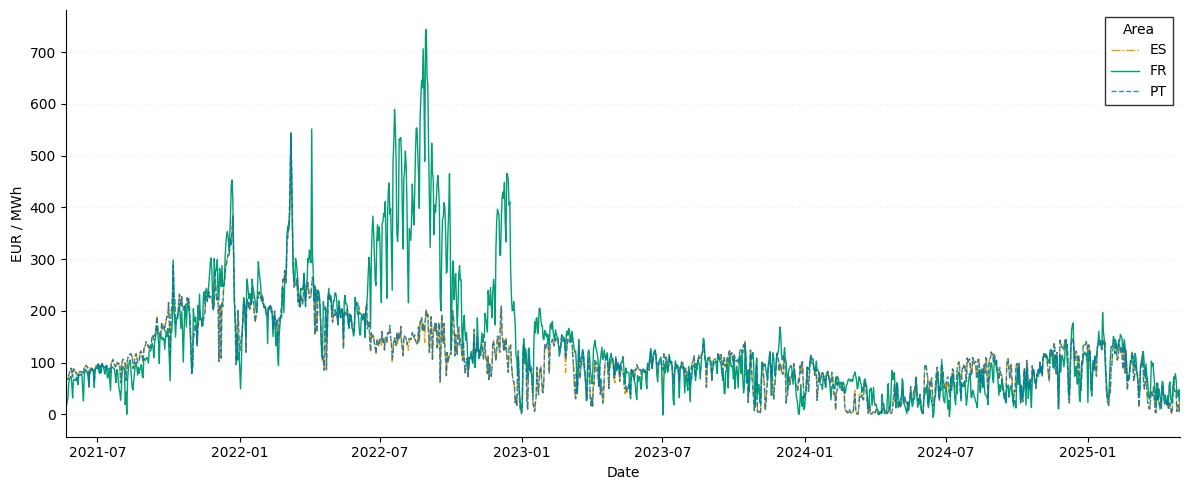

In [40]:

# ────────────────────────────────────────────────────────────────
# CONFIG — adjust if your variable names differ
# ────────────────────────────────────────────────────────────────
TIMESTAMP_COL   = 'Start DateTime'
PRICE_COL       = 'Day-ahead Price (EUR/MWh)'
AREA_COL        = 'Area'

STYLE_MAP = {
    'PT': {'color': '#0072B2', 'linestyle': '--', 'linewidth': 1, 'alpha':0.8},
    'ES': {'color': '#E69F00', 'linestyle': '-.', 'linewidth': 1},
    'FR': {'color': '#009E73', 'linestyle': '-',  'linewidth': 1}
}

# Directory & filename for the LaTeX table
LATEX_DIR = 'latex_files'
os.makedirs(LATEX_DIR, exist_ok=True)
table_path = os.path.join(LATEX_DIR, f"stats_{option_selector.value}.tex")

# ────────────────────────────────────────────────────────────────
# 1) Pre‑processing
# ────────────────────────────────────────────────────────────────
df = filtered_df.copy()

# Convert timestamp, set index
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df.set_index(TIMESTAMP_COL, inplace=True)

# Remove the "BZN|" prefix from area labels (case‑insensitive)
df[AREA_COL] = df[AREA_COL].str.replace(r'(?i)^BZN\|', '', regex=True)

# ────────────────────────────────────────────────────────────────
# 2) Descriptive statistics BY AREA  →  save as LaTeX
# ────────────────────────────────────────────────────────────────
stats_by_area = (
    df
    .groupby(AREA_COL)[PRICE_COL]
    .describe()
)

stats_by_area.to_latex(
    table_path,
    float_format="%.2f",
    caption="Descriptive statistics of hourly day‑ahead prices by area",
    label=f"tab:stats_{option_selector.value}"
)
print(f"LaTeX table saved to: {table_path}")

# ────────────────────────────────────────────────────────────────
# 3) Daily average prices BY AREA
# ────────────────────────────────────────────────────────────────
daily_pivot = (
    df
    .groupby(AREA_COL)[PRICE_COL]
    .resample('D')
    .mean()
    .unstack(level=0)
    .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 4) Plot
# ────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

for area in daily_pivot.columns:
    style = STYLE_MAP.get(area, {})
    ax.plot(daily_pivot.index, daily_pivot[area], label=area, **style)


# axes / legend refinements
ax.set_xlim(daily_pivot.index.min(), daily_pivot.index.max())      
ax.set_xlabel('Date')
ax.set_ylabel('EUR / MWh')
ax.yaxis.grid(True, linestyle='--', alpha=0.1)   
ax.xaxis.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ('left', 'bottom'):
    ax.spines[spine].set_color('black')

# black tick labels / ticks
ax.tick_params(axis='both', colors='black')


# legend INSIDE the axes (upper-right), boxed
leg = ax.legend(
    title='Area',
    loc='upper right',          # inside
    frameon=True,
    facecolor='white',          # legend background
    edgecolor='black',          # legend border
    fancybox=False              # square corners (set True if you prefer rounded)
)


# drop the legend title’s bold font
leg.get_title().set_fontweight('normal')

plt.tight_layout()
plt.show()



LaTeX table saved to →  latex_files\stats_europe.tex


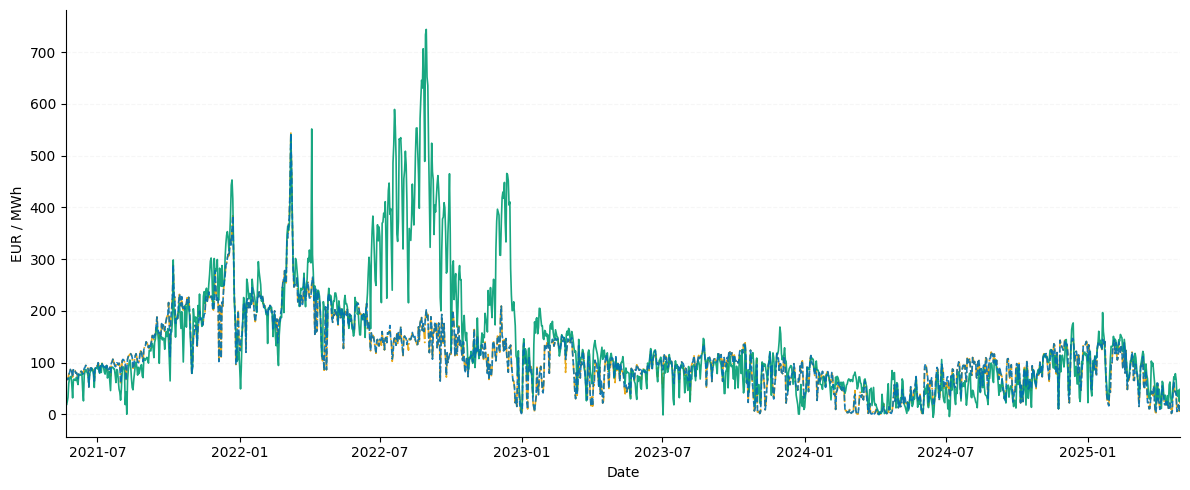

In [45]:
# ---------------------------------------------------------------
# 1)  CONFIGURATION
# ---------------------------------------------------------------
TIMESTAMP_COL = 'Start DateTime'
PRICE_COL     = 'Day-ahead Price (EUR/MWh)'
AREA_COL      = 'Area'

# Colour-blind friendly palette + distinct line styles
STYLE_MAP = {
    'PT': {'color': '#0072B2', 'linestyle': '--', 'linewidth': 1.2, 'alpha': .9},
    'ES': {'color': '#E69F00', 'linestyle': '-.', 'linewidth': 1.2, 'alpha': .9},
    'FR': {'color': '#009E73', 'linestyle': '-',  'linewidth': 1.2, 'alpha': .9},
}

# where to save the LaTeX table
LATEX_DIR  = 'latex_files'
os.makedirs(LATEX_DIR, exist_ok=True)
table_path = os.path.join(LATEX_DIR, f"stats_{option_selector.value}.tex")

# ---------------------------------------------------------------
# 2)  DATA WRANGLING
# ---------------------------------------------------------------
df = filtered_df.copy()

df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df.set_index(TIMESTAMP_COL, inplace=True)

# strip the `BZN|` prefix
df[AREA_COL] = df[AREA_COL].str.replace(r'(?i)^BZN\|', '', regex=True)

# ---------------------------------------------------------------
# 3)  DESCRIPTIVE STATISTICS  (per area)
# ---------------------------------------------------------------
stats = (
    df.groupby(AREA_COL)[PRICE_COL]
      .describe()
      .loc[:, ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
      .round({'mean': 1, 'std': 1, '25%': 1, '50%': 1, '75%': 1, 'min': 1, 'max': 1})
)

# helper: produce a TikZ line sample + area label
def area_cell(area):
    hex_color = STYLE_MAP[area]['color'].lstrip('#')
    mpl_line  = STYLE_MAP[area]['linestyle']

    if mpl_line == '--':
        tikz_dash = 'dashed'
    elif mpl_line == '-.':
        tikz_dash = 'dash pattern=on 4pt off 2pt on 1pt off 2pt'
    else:
        tikz_dash = ''                          # solid line

    tikz_opts = (
        f"color={{[HTML]{{{hex_color}}}}},"    # colour
        f"{tikz_dash}," if tikz_dash else ""
        "line width=1pt"
    )
    # escape braces {{ }} so they pass through the f-string
    return rf"\tikz[baseline=-0.5ex]{{{{\draw[{tikz_opts}] (0,0)--(0.9,0);}}}}~{area}"

# build the LaTeX tabular manually so we can inject that cell
latex_lines = [
    r"\begin{tabular}{l"
    r"S[table-format=5.0] S[table-format=4.1] S[table-format=4.1]"
    r"S[table-format=5.1] S[table-format=4.1] S[table-format=4.1]"
    r"S[table-format=4.1] S[table-format=5.1]}",
    r"\toprule",
    r"Area & {Count} & {Mean} & {SD} & {Min} & {Q1} & {Med.} & {Q3} & {Max}\\",
    r"\midrule",
]

for area, row in stats.iterrows():
    latex_row = " & ".join([area_cell(area)] + [f"{v}" for v in row.values]) + r" \\"
    latex_lines.append(latex_row)

latex_lines += [r"\bottomrule", r"\end{tabular}"]

with open(table_path, "w") as f:
    f.write("\n".join(latex_lines))

print(f"LaTeX table saved to →  {table_path}")

# ---------------------------------------------------------------
# 4)  DAILY AVERAGES  +  PLOT  (no legend)
# ---------------------------------------------------------------
daily_pivot = (
    df.groupby(AREA_COL)[PRICE_COL]
      .resample('D')
      .mean()
      .unstack(level=0)
      .sort_index()
)

fig, ax = plt.subplots(figsize=(12, 5))

for area in daily_pivot.columns:
    ax.plot(daily_pivot.index, daily_pivot[area], **STYLE_MAP[area])

# clean look
ax.set_xlim(daily_pivot.index.min(), daily_pivot.index.max())
ax.set_xlabel('Date')
ax.set_ylabel('EUR / MWh')
ax.yaxis.grid(True, linestyle='--', alpha=.1)
ax.xaxis.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for s in ('left', 'bottom'):
    ax.spines[s].set_color('black')
ax.tick_params(axis='both', colors='black')






plt.tight_layout()
plt.show()



 ## Step 7: Export Filtered Data

Save the cleaned and validated dataset to a Parquet file for further use.

In [30]:
if option_selector.value == 'australia':
    filtered_df.to_parquet('parquet_files/filtered_data_australia.parquet', index=False)
else:
    filtered_df.to_parquet('parquet_files/filtered_data.parquet', index=False)